**Importing Required Libraries**

In [27]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import MinMaxScaler

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout

**Reading the dataset**

In [28]:
#read the file
df = pd.read_csv("/content/datasets_423609_1456925_INFY.csv")

#print the head
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,INFOSYSTCH,EQ,14467.75,15625.00,15625.20,15625.00,15625.20,15625.20,15625.18,5137,8.026657e+12,NaN,NaN,NaN
1,2000-01-04,INFOSYSTCH,EQ,15625.20,16800.00,16875.25,16253.00,16875.25,16855.90,16646.38,56186,9.352937e+13,NaN,NaN,NaN
2,2000-01-05,INFOSYSTCH,EQ,16855.90,15701.00,16250.00,15507.45,15507.45,15507.45,15786.38,164605,2.598516e+14,NaN,NaN,NaN
3,2000-01-06,INFOSYSTCH,EQ,15507.45,15256.65,15300.00,14266.85,14266.85,14266.85,14462.82,81997,1.185908e+14,NaN,NaN,NaN
4,2000-01-07,INFOSYSTCH,EQ,14266.85,13125.50,13125.50,13125.50,13125.50,13125.50,13125.50,7589,9.960942e+12,NaN,NaN,NaN


**Setting Date as Index. Using Close Price for prediction**

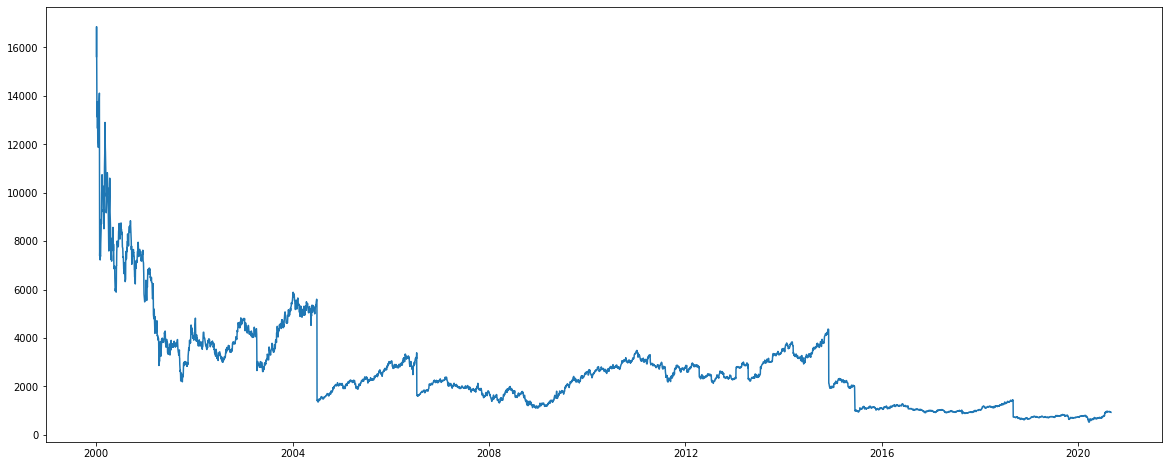

In [29]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(20,8))
plt.plot(df['Close'], label='Historical Close Price')

**Selecting Close Price as feature and removing other columns from the data**

In [30]:
features = ["Date", "Close"]
all_data = df[features]

In [31]:
#setting index
all_data.index = all_data.Date
all_data.drop('Date', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [32]:
all_data.head()

,Close
Date,
2000-01-03,15625.20
2000-01-04,16855.90
2000-01-05,15507.45
2000-01-06,14266.85
2000-01-07,13125.50


In [33]:
all_data.shape

(5141, 1)

In [34]:
#creating training and validation sets
dataset = all_data.values

train = dataset[2000:4500,:]
valid = dataset[4500:,:]

**Feature Scaling**

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

**Creating Sliding Window of 90 days**

In [36]:
x_train, y_train = [], []
for i in range(90,len(train)):
    x_train.append(scaled_data[i-90:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

**Data Reshaping**

In [37]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

**Model Building**

Initializing the LSTM model and 2nd, 3rd and 4th LSTM layer each with a Dropout Layer. The layers contain 50 neurons and with a Dropout rate of 20%, twenty percent of 50 neurons will be ignored randomly during each iteration

Finally, an output layer is added with 1 as an output dimension (as we are predicting the close price)

In [38]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = False))
model.add(Dropout(rate = 0.2))

model.add(Dense(1))

Compiling the model with **Stochastic Gradient Descent** algorithm

Using Mean Squared Error as Loss Function

In [39]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [40]:
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
38/38 [==============================] - 8s 202ms/step - loss: 0.0051
Epoch 2/100
38/38 [==============================] - 8s 202ms/step - loss: 0.0014
Epoch 3/100
38/38 [==============================] - 8s 199ms/step - loss: 0.0012
Epoch 4/100
38/38 [==============================] - 8s 207ms/step - loss: 0.0011
Epoch 5/100
38/38 [==============================] - 8s 207ms/step - loss: 9.8862e-04
Epoch 6/100
38/38 [==============================] - 8s 200ms/step - loss: 0.0010
Epoch 7/100
38/38 [==============================] - 8s 204ms/step - loss: 9.8929e-04
Epoch 8/100
38/38 [==============================] - 8s 202ms/step - loss: 9.2591e-04
Epoch 9/100
38/38 [==============================] - 8s 205ms/step - loss: 8.8854e-04
Epoch 10/100
38/38 [==============================] - 8s 206ms/step - loss: 7.8317e-04
Epoch 11/100
38/38 [==============================] - 8s 200ms/step - loss: 7.4112e-04
Epoch 12/100
38/38 [==============================] - 8s 208ms/step - lo

**Preparing the Test data for prediction**

In [41]:
#predicting test data values, using past 90 from the train data
inputs = all_data[len(all_data) - len(valid)-90:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [42]:
inputs.shape

(731, 1)

In [43]:
X_test = []
for i in range(90,inputs.shape[0]):
    X_test.append(inputs[i-90:i,0])
X_test = np.array(X_test)

In [44]:
X_test

array([[0.02338107, 0.02343312, 0.02362603, ..., 0.03778449, 0.03818561,
        0.03984519],
       [0.02343312, 0.02362603, 0.02365358, ..., 0.03818561, 0.03984519,
        0.04037797],
       [0.02362603, 0.02365358, 0.02346068, ..., 0.03984519, 0.04037797,
        0.03974108],
       ...,
       [0.00653727, 0.00706699, 0.00936039, ..., 0.02577858, 0.02520905,
        0.02598679],
       [0.00706699, 0.00936039, 0.008056  , ..., 0.02520905, 0.02598679,
        0.02575714],
       [0.00936039, 0.008056  , 0.00846017, ..., 0.02598679, 0.02575714,
        0.02503452]])

In [45]:
X_test.shape

(641, 90)

In [46]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)

In [47]:
preds

array([[1289.8188 ],
       [1303.6515 ],
       [1308.7808 ],
       [1311.2748 ],
       [1307.949  ],
       [1296.3668 ],
       [1284.7076 ],
       [1277.8086 ],
       [1273.4635 ],
       [1259.9264 ],
       [1248.3718 ],
       [1251.974  ],
       [1250.0455 ],
       [1242.9579 ],
       [1235.1604 ],
       [1236.6605 ],
       [1246.135  ],
       [1255.4777 ],
       [1262.39   ],
       [1269.6156 ],
       [1279.384  ],
       [1284.516  ],
       [1279.6134 ],
       [1277.9507 ],
       [1287.6405 ],
       [1293.2859 ],
       [1292.6116 ],
       [1288.5713 ],
       [1282.7109 ],
       [1283.4725 ],
       [1289.07   ],
       [1301.96   ],
       [1311.1787 ],
       [1313.4547 ],
       [1313.0507 ],
       [1308.3867 ],
       [1294.9274 ],
       [1290.711  ],
       [1293.5709 ],
       [1294.8949 ],
       [1296.8398 ],
       [1293.6127 ],
       [1289.0607 ],
       [1277.9023 ],
       [1270.7986 ],
       [1269.8357 ],
       [1265.1825 ],
       [1269.

**Calculating the RMSE to evaluate the model performance**

In [48]:
rms=np.sqrt(np.mean(np.power((valid-preds),2)))

**Plotting the output**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


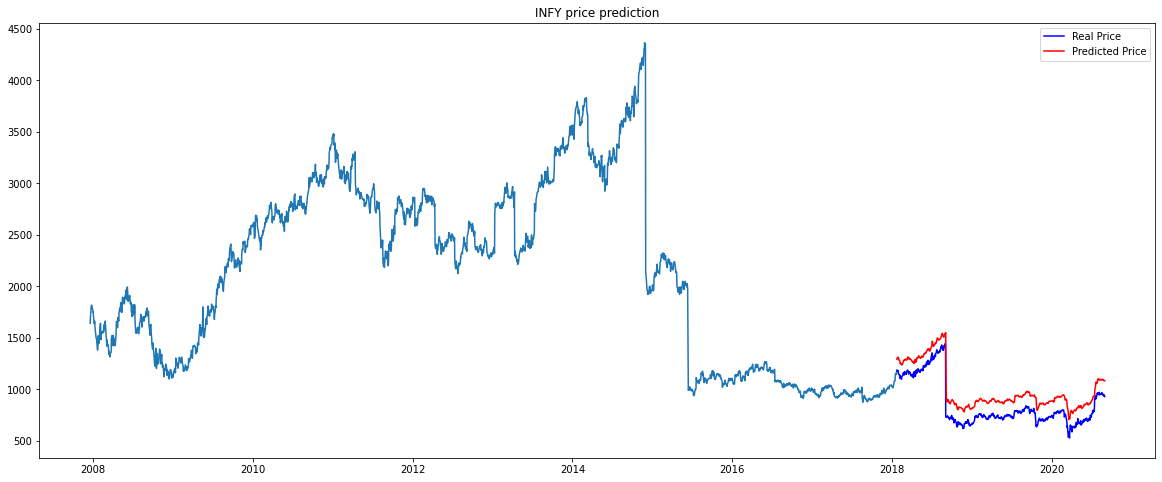

In [49]:
#for plotting
train = all_data[2000:4500]
valid = all_data[4500:]
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(train['Close'])
plt.plot(valid['Close'], color = 'blue', label = 'Real Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Price')
plt.title('INFY price prediction')
plt.legend()
plt.show()